In [2]:
#--------------------------------
# Imports
#--------------------------------
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray
import datetime
import calendar
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import matplotlib
import pickle
import pandas as pd
import pandas
import metpy.calc as mpcalc
from metpy.units import units
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter as GF
import metpy
import matplotlib.ticker as ticker
import metpy.calc as mpcalc
from netCDF4 import Dataset
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units
from dask.distributed import Client, progress, LocalCluster
#import wrf
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib import cm
import PseudoNetCDF as pnc

# Read in P-3B flight path, the file for which is publicly available on the NASA CAMP2Ex data portal (https://www-air.larc.nasa.gov/cgi-bin/ArcView/camp2ex)

In [3]:
# Pull in P3 Flight Path
path = '/discover/nobackup/mwstanfo/camp2ex_data/p3/20190925/'
p3_file = path+'CAMP2EX-MetNav_P3B_20190925_R0.ict'

infile = pnc.pncopen(p3_file, format = 'ffi1001')
var_list = infile.variables
keys = list(var_list.keys())

p3_lat = var_list['Latitude'].data # Pressure altitude (ft)
p3_lon = var_list['Longitude'].data # Pressure altitude (ft)


# Read in Learjet flight path, also on the data portal

In [4]:
# Pull in Learjet Flight Path
path = '/discover/nobackup/mwstanfo/camp2ex_data/learjet/20190925/'
learjet_file = path+'CAMP2Ex-Page0_Learjet_20190925_R0.ict'

infile = pnc.pncopen(learjet_file, format = 'ffi1001')
var_list = infile.variables
keys = list(var_list.keys())
#print(keys)

learjet_lat = var_list['Lat'].data # Pressure altitude (ft)
learjet_lon = var_list['Long'].data # Pressure altitude (ft)

# Read in NUWRF geo_em file, which can be recreated by using the namelist.wps file provided on the NCCS data portal. The geo_em* files are also provided on the portal (https://portal.nccs.nasa.gov/datashare/giss-camp2ex/). 

In [53]:
path = '/discover/nobackup/mwstanfo/acp_camp2ex_ms_data/nuwrf/'

d01_file = path+'geo_em.d01.nc'
d02_file = path+'geo_em.d02.nc'
#d01_ncfile = Dataset(d01_file)
#d02_ncfile = Dataset(d02_file)
#d01_lat = wrf.getvar(d01_ncfile,'XLAT_M',meta=False).T
#d01_lon = wrf.getvar(d01_ncfile,'XLONG_M',meta=False).T
#d02_lat = wrf.getvar(d02_ncfile,'XLAT_M',meta=False).T
#d02_lon = wrf.getvar(d02_ncfile,'XLONG_M',meta=False).T
#d01_ncfile.close()
#d02_ncfile.close()
d01_ds = xarray.open_dataset(d01_file)
d02_ds = xarray.open_dataset(d02_file)
d01_lat = d01_ds['XLAT_M'].values.squeeze()
d01_lon = d01_ds['XLONG_M'].values.squeeze()
d02_lat = d02_ds['XLAT_M'].values.squeeze()
d02_lon = d02_ds['XLONG_M'].values.squeeze()
d01_ds.close()
d02_ds.close()

#d01_lon_1d = d01_lon[:,0]
#d01_lat_1d = d01_lat[0,:]
#d02_lon_1d = d02_lon[:,0]
#d02_lat_1d = d02_lat[0,:]
d01_lon_1d = d01_lon[0,:]
d01_lat_1d = d01_lat[:,0]
d02_lon_1d = d02_lon[0,:]
d02_lat_1d = d02_lat[:,0]

# Plot NUWRF domain and flight paths (Fig. 4 of manuscript)

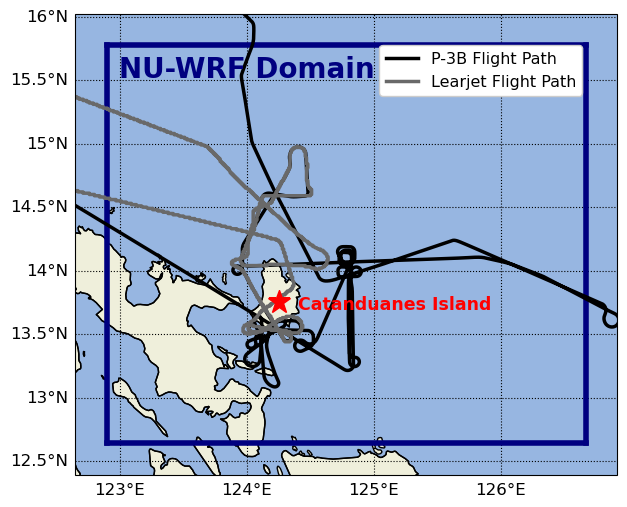

In [56]:
fig = plt.figure(figsize=(7,7))
Fontsize=10
ax = fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND,edgecolor='black')

g1 = ax.gridlines(color='black',linestyle='dotted')
g1.bottom_labels = True
g1.left_labels = True
g1.xlabel_style = {'size':12}
g1.ylabel_style = {'size':12}
ax.tick_params(labelsize=Fontsize)  

ax.set_ylim(d02_lat_1d.min()-0.25,d02_lat_1d.max()+0.25)
ax.set_xlim(d02_lon_1d.min()-0.25,d02_lon_1d.max()+0.25)


ax.plot([d02_lon_1d[0],d02_lon_1d[0]],[d02_lat_1d[0],d02_lat_1d[-1]],lw=4,c='navy')
ax.plot([d02_lon_1d[-1],d02_lon_1d[-1]],[d02_lat_1d[0],d02_lat_1d[-1]],lw=4,c='navy')
ax.plot([d02_lon_1d[0],d02_lon_1d[-1]],[d02_lat_1d[0],d02_lat_1d[0]],lw=4,c='navy')
ax.plot([d02_lon_1d[0],d02_lon_1d[-1]],[d02_lat_1d[-1],d02_lat_1d[-1]],lw=4,c='navy')

ax.text(d02_lon_1d[0]+0.1,d02_lat_1d[-1]-0.25,'NU-WRF Domain',fontweight='bold',fontsize=Fontsize*2,c='navy')

# Plot P3 path
ax.plot(p3_lon,p3_lat,c='k',lw=2.5,label='P-3B Flight Path')

# Plot Learjet Path
ax.plot(learjet_lon,learjet_lat,c='dimgrey',lw=2.5,label='Learjet Flight Path')


ax.legend(loc='upper right',framealpha=1,fontsize=Fontsize*1.15,bbox_to_anchor=(0.95,0.95))

cat_lon = 124.25
cat_lat = 13.75

ax.plot(cat_lon,cat_lat,marker='*',c='red',markersize=17)
ax.text(cat_lon+0.15,cat_lat-0.05,'Catanduanes Island',fontsize=Fontsize*1.25,fontweight='bold',c='red')

fig_path = '/discover/nobackup/mwstanfo/figures/camp2ex_paper/'
outfile = 'fig_04.png'
#plt.savefig(fig_path+outfile,dpi=300,bbox_inches='tight')
plt.show()
plt.close()